# Дипломный проект: Реконструирование коэффициента Кендалла (W) и стандартной ошибки оценок жюри (Rho) 
Карпеченко Д.М.

Постановка задачи.
Несколько членов жюри одновременно оценивают два-четыре доклада, выставляя им целочисленные оценки. В идеале, оценки от разных членов жюри должны совпадать. В реальности они чаще не совпадают (каждый член жюри оценивает и ранжирует команды по-своему). Парамером, оценивающим согласованность судейства, является коэффициент Кендалла W (W=1, если каждый из жюри ранжирует команды в одном и том же порядке. W=0, если каждый член жюри ранжирует команды по-своему, и в работе жюри полная несогласованность). В данных имеются 707 записей с обширными метаданными, где коэффициент Кендалла W напрямую вычислен на основе отдельных оценок жюри. Также имеются 375 записей, где метаданные есть, а оценок жюри нет, и напрямую вычислить коэффициент Кендалла невозможно. В этом дипломном проекте предлагается реконструировать коэффициент Кендалла, опираясь только на метаданные. 

Результат работы.
Истинные и реконструированные тремя разными методами значения W коррелируют (коэффициент корреляции около 0,55). Рапределения рекоструированных W имеют те же свойства, что и распределения истинных W. Реконструированные W подчиняются тем же закономерностям, что и истинные W. В частности: при близких результах команд W близок к 0 (команды равносильны, жюри не могут их согласованно ранжировать), а при сильно различающихся результатах команд (сильные и слабые доклады, жюри легко их ранжировать) W близок к 1. Реконструированные W, таким образом, можно считать достаточно правдоподобным и достоверным отражением реальности.

Примечание.
Вторым параметром, оценивающим согласованность судейства, является стандартная ошибка оценок жюри (среднеквадратичное отклонение отдельных оценок от среднего, деленное на корень из числа степеней свободы). Данный параметр успешно реконструировать не удалось. Возможно это связано с тем, что такая ошибка является случайной переменной.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

#Снять ограничения на вывод колонок
pd.set_option('display.max_columns', None)
#Снять ограничения на вывод строк
pd.set_option('display.max_rows', 15)


In [2]:
data = pd.read_excel('TestTrain.xlsx')

In [3]:
data

,Year,PF,1st_place,SPm_1,P_1,2nd_place,SPm_2,P_2,3rd_place,SPm_3,P_3,4th_place,SPm_4,P_4,T1,T2,T3,T4,W,Rho,T,J,Y,Dte,Dte.1
0,1990,1-A,USSR-Riga,46.58,7,Czechoslovakia,43.08,2,Poland,35.79,5.0,NaN,NaN,NaN,2,3,1.0,NaN,0.866,0.858,3,11,0,9.6,161
1,1990,F-A,USSR-Moscow,42.50,6,USSR-Riga,39.87,3,Netherlands,29.97,4.0,NaN,NaN,NaN,3,1,2.0,NaN,0.551,1.170,3,7,0,12.6,164
2,1993,1-A,Netherlands,39.80,8,Poland,37.30,11,Ukraine,22.60,15.0,NaN,NaN,NaN,1,2,3.0,NaN,0.796,0.927,3,7,0,19.6,170
3,1993,2-A,Hungary,37.40,9,Russia,33.90,7,Russia,30.30,3.0,NaN,NaN,NaN,1,2,3.0,NaN,0.327,0.804,3,7,0,20.6,171
4,1993,2-B,Netherlands,48.40,2,Russia,43.80,14,Ukraine,41.00,12.0,NaN,NaN,NaN,3,1,2.0,NaN,0.500,1.337,3,7,0,20.6,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2022,5-E,Bulgaria,27.60,7,United Kingdom,27.50,15,India,24.50,5.0,NaN,NaN,NaN,1,3,2.0,NaN,0.040,0.895,3,5,0,21.7,202
703,2022,5-F,Chinese Taipei,41.10,6,Greece,24.30,7,Sweden,20.10,11.0,NaN,NaN,NaN,2,3,1.0,NaN,0.958,0.882,3,5,3,21.7,202
704,2022,5-G,Singapore,45.80,9,South Africa,28.40,7,Iran,26.70,11.0,NaN,NaN,NaN,1,3,2.0,NaN,0.832,0.771,3,5,2,21.7,202
705,2022,5-H,Poland,37.00,16,Germany,32.40,2,Croatia,26.90,1.0,NaN,NaN,NaN,1,3,2.0,NaN,0.933,0.827,3,5,2,21.7,202


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       707 non-null    int64  
 1   PF         707 non-null    object 
 2   1st_place  707 non-null    object 
 3   SPm_1      707 non-null    float64
 4   P_1        707 non-null    int64  
 5   2nd_place  707 non-null    object 
 6   SPm_2      707 non-null    float64
 7   P_2        707 non-null    int64  
 8   3rd_place  702 non-null    object 
 9   SPm_3      702 non-null    float64
 10  P_3        702 non-null    float64
 11  4th_place  80 non-null     object 
 12  SPm_4      80 non-null     float64
 13  P_4        80 non-null     float64
 14  T1         707 non-null    int64  
 15  T2         707 non-null    int64  
 16  T3         702 non-null    float64
 17  T4         80 non-null     float64
 18  W          707 non-null    float64
 19  Rho        707 non-null    float64
 20  T         

Видим много пропусков из-за того, что в разных боях могут принимать участие от двух до четырёх команд. Наиболее частый случай - три команды. Проанализируем, насколько в среднем отличаются быллы у третьего от второго места, и четвертого от третьего. Для сохранения информации заполним пропуски в командах на No team, а баллы за третье место и четвертое - с учетом средней разницы.

In [5]:
import sqlite3
con = sqlite3.connect('db')
data.to_sql('TestTrain', con, index=False, if_exists='replace')

707

In [6]:
sql2 = '''select SPm_1,SPm_2,SPm_3,SPm_4,avg(SPm_3-SPm_4),avg(SPm_2-SPm_3) from TestTrain where T==4'''
graf=pd.read_sql(sql2,con)
graf

,SPm_1,SPm_2,SPm_3,SPm_4,avg(SPm_3-SPm_4),avg(SPm_2-SPm_3)
0,52.65,45.99,42.66,41.15,4.460125,3.644125


In [7]:
data.loc[(data['3rd_place'].isnull()), '3rd_place']='No team'
data.loc[(data['SPm_3'].isnull()), 'SPm_3']=data['SPm_2']-3.64
data.loc[(data['P_3'].isnull()), 'P_3']=0
data.loc[(data['T3'].isnull()), 'T3']=0


In [8]:
data.loc[(data['4th_place'].isnull()), '4th_place']='No team'
data.loc[(data['SPm_4'].isnull()), 'SPm_4']=data['SPm_3']-4.46
data.loc[(data['P_4'].isnull()), 'P_4']=0
data.loc[(data['T4'].isnull()), 'T4']=0

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       707 non-null    int64  
 1   PF         707 non-null    object 
 2   1st_place  707 non-null    object 
 3   SPm_1      707 non-null    float64
 4   P_1        707 non-null    int64  
 5   2nd_place  707 non-null    object 
 6   SPm_2      707 non-null    float64
 7   P_2        707 non-null    int64  
 8   3rd_place  707 non-null    object 
 9   SPm_3      707 non-null    float64
 10  P_3        707 non-null    float64
 11  4th_place  707 non-null    object 
 12  SPm_4      707 non-null    float64
 13  P_4        707 non-null    float64
 14  T1         707 non-null    int64  
 15  T2         707 non-null    int64  
 16  T3         707 non-null    float64
 17  T4         707 non-null    float64
 18  W          707 non-null    float64
 19  Rho        707 non-null    float64
 20  T         

In [10]:
data.drop(['Dte'], axis = 1, inplace = True)

In [11]:
data["P_3"] = data['P_3'].astype('int')
data["P_4"] = data['P_4'].astype('int')
data["T3"] = data['T3'].astype('int')
data["T4"] = data['T4'].astype('int')

Проверим, в каких пределах лежат целевые метки

In [12]:
data['W'].describe()

count    707.000000
mean       0.654163
std        0.275409
min        0.007000
25%        0.465000
50%        0.760000
75%        0.847500
max        1.000000
Name: W, dtype: float64

In [13]:
data['Rho'].describe()

count    707.000000
mean       0.885364
std        0.192335
min        0.408000
25%        0.753500
50%        0.872000
75%        0.992500
max        1.832000
Name: Rho, dtype: float64

array([[<Axes: title={'center': 'W'}>, <Axes: title={'center': 'Rho'}>]],
      dtype=object)

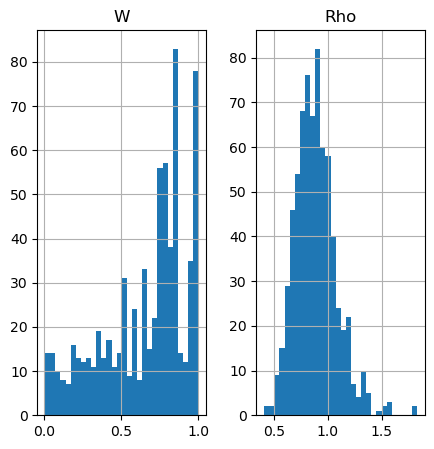

In [14]:
data.hist(column=['W', 'Rho'],bins = 30, figsize = (5, 5))

In [15]:
data

,Year,PF,1st_place,SPm_1,P_1,2nd_place,SPm_2,P_2,3rd_place,SPm_3,P_3,4th_place,SPm_4,P_4,T1,T2,T3,T4,W,Rho,T,J,Y,Dte.1
0,1990,1-A,USSR-Riga,46.58,7,Czechoslovakia,43.08,2,Poland,35.79,5,No team,31.33,0,2,3,1,0,0.866,0.858,3,11,0,161
1,1990,F-A,USSR-Moscow,42.50,6,USSR-Riga,39.87,3,Netherlands,29.97,4,No team,25.51,0,3,1,2,0,0.551,1.170,3,7,0,164
2,1993,1-A,Netherlands,39.80,8,Poland,37.30,11,Ukraine,22.60,15,No team,18.14,0,1,2,3,0,0.796,0.927,3,7,0,170
3,1993,2-A,Hungary,37.40,9,Russia,33.90,7,Russia,30.30,3,No team,25.84,0,1,2,3,0,0.327,0.804,3,7,0,171
4,1993,2-B,Netherlands,48.40,2,Russia,43.80,14,Ukraine,41.00,12,No team,36.54,0,3,1,2,0,0.500,1.337,3,7,0,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2022,5-E,Bulgaria,27.60,7,United Kingdom,27.50,15,India,24.50,5,No team,20.04,0,1,3,2,0,0.040,0.895,3,5,0,202
703,2022,5-F,Chinese Taipei,41.10,6,Greece,24.30,7,Sweden,20.10,11,No team,15.64,0,2,3,1,0,0.958,0.882,3,5,3,202
704,2022,5-G,Singapore,45.80,9,South Africa,28.40,7,Iran,26.70,11,No team,22.24,0,1,3,2,0,0.832,0.771,3,5,2,202
705,2022,5-H,Poland,37.00,16,Germany,32.40,2,Croatia,26.90,1,No team,22.44,0,1,3,2,0,0.933,0.827,3,5,2,202


In [16]:
data2=data.copy()

In [17]:
corr_matrix = data.corr()

C:\Users\HP\AppData\Local\Temp\ipykernel_18724\962194556.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


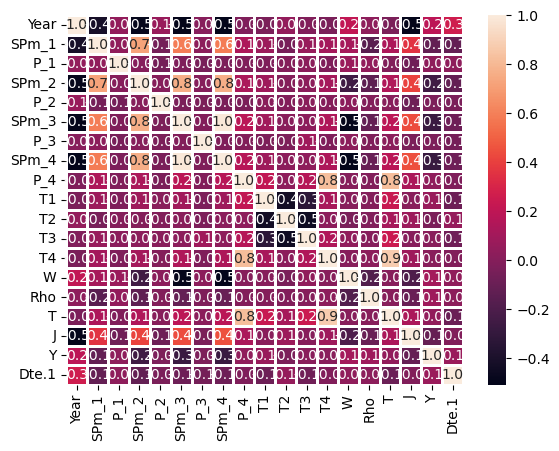

In [18]:
sns.heatmap(corr_matrix, annot=True, linewidths=1, fmt=".1f");

Проведем get_dummies кодирование для категориальных значений

In [19]:
data=pd.concat([data, 
            pd.get_dummies(data['PF'], prefix='PF'),
            pd.get_dummies(data['1st_place'], prefix='1st_place'),
            pd.get_dummies(data['2nd_place'], prefix='2nd_place'),
            pd.get_dummies(data['3rd_place'], prefix='3rd_place'),
            pd.get_dummies(data['4th_place'], prefix='4th_place')], axis=1)

In [20]:
data=data.drop(['PF','1st_place','2nd_place','3rd_place','4th_place'],axis=1)

In [21]:
data

,Year,SPm_1,P_1,SPm_2,P_2,SPm_3,P_3,SPm_4,P_4,T1,T2,T3,T4,W,Rho,T,J,Y,Dte.1,PF_1-A,PF_1-B,PF_1-C,PF_1-D,PF_1-E,PF_1-F,PF_1-G,PF_1-H,PF_1-I,PF_1-J,PF_1-K,PF_2-A,PF_2-B,PF_2-C,PF_2-D,PF_2-E,PF_2-F,PF_2-G,PF_2-H,PF_2-I,PF_2-J,PF_2-K,PF_3-A,PF_3-B,PF_3-C,PF_3-D,PF_3-E,PF_3-F,PF_3-G,PF_3-H,PF_3-I,PF_3-J,PF_3-K,PF_4-A,PF_4-B,PF_4-C,PF_4-D,PF_4-E,PF_4-F,PF_4-G,PF_4-H,PF_4-I,PF_4-J,PF_4-K,PF_5-A,PF_5-B,PF_5-C,PF_5-D,PF_5-E,PF_5-F,PF_5-G,PF_5-H,PF_5-I,PF_5-J,PF_5-K,PF_F-A,PF_S-A,1st_place_Australia,1st_place_Austria,1st_place_Belarus,1st_place_Brazil,1st_place_Bulgaria,1st_place_Canada,1st_place_China,1st_place_Chinese Taipei,1st_place_Croatia,1st_place_Czech Republic,1st_place_France,1st_place_Georgia,1st_place_Germany,1st_place_Greece,1st_place_Hungary,1st_place_India,1st_place_Indonesia,1st_place_Iran,1st_place_Kenya,1st_place_Netherlands,1st_place_New Zealand,1st_place_Poland,1st_place_Romania,1st_place_Russia,1st_place_Serbia,1st_place_Singapore,1st_place_Slovakia,1st_place_South Korea,1st_place_Sweden,1st_place_Switzerland,1st_place_Thailand,1st_place_USSR-Moscow,1st_place_USSR-Riga,1st_place_Ukraine,1st_place_United Kingdom,1st_place_United States,2nd_place_Australia,2nd_place_Austria,2nd_place_Belarus,2nd_place_Brazil,2nd_place_Bulgaria,2nd_place_Canada,2nd_place_China,2nd_place_Chinese Taipei,2nd_place_Croatia,2nd_place_Czech Republic,2nd_place_Czechoslovakia,2nd_place_Finland,2nd_place_France,2nd_place_Georgia,2nd_place_Germany,2nd_place_Greece,2nd_place_Hungary,2nd_place_India,2nd_place_Indonesia,2nd_place_Iran,2nd_place_Kazakhstan,2nd_place_Kenya,2nd_place_Macao,2nd_place_Mexico,2nd_place_Netherlands,2nd_place_New Zealand,2nd_place_Nigeria,2nd_place_Pakistan,2nd_place_Poland,2nd_place_Romania,2nd_place_Russia,2nd_place_Serbia,2nd_place_Singapore,2nd_place_Slovakia,2nd_place_Slovenia,2nd_place_South Africa,2nd_place_South Korea,2nd_place_Sweden,2nd_place_Switzerland,2nd_place_Thailand,2nd_place_Turkey,2nd_place_USSR-Riga,2nd_place_Ukraine,2nd_place_United Kingdom,2nd_place_United States,2nd_place_Uzbekistan,3rd_place_Australia,3rd_place_Austria,3rd_place_Azerbaijan,3rd_place_Belarus,3rd_place_Brazil,3rd_place_Bulgaria,3rd_place_Canada,3rd_place_Chile,3rd_place_China,3rd_place_Chinese Taipei,3rd_place_Croatia,3rd_place_Cyprus,3rd_place_Czech Republic,3rd_place_Finland,3rd_place_France,3rd_place_Georgia,3rd_place_Germany,3rd_place_Greece,3rd_place_Hungary,3rd_place_India,3rd_place_Indonesia,3rd_place_Iran,3rd_place_Kazakhstan,3rd_place_Kenya,3rd_place_Macao,3rd_place_Mexico,3rd_place_Netherlands,3rd_place_New Zealand,3rd_place_Nigeria,3rd_place_No team,3rd_place_Pakistan,3rd_place_Poland,3rd_place_Romania,3rd_place_Russia,3rd_place_Serbia,3rd_place_Singapore,3rd_place_Slovakia,3rd_place_Slovenia,3rd_place_South Africa,3rd_place_South Korea,3rd_place_Sweden,3rd_place_Switzerland,3rd_place_Thailand,3rd_place_Turkey,3rd_place_Ukraine,3rd_place_United Arab Em,3rd_place_United Kingdom,3rd_place_United States,4th_place_Australia,4th_place_Austria,4th_place_Belarus,4th_place_Bulgaria,4th_place_Canada,4th_place_Chile,4th_place_China,4th_place_Chinese Taipei,4th_place_Czech Republic,4th_place_Georgia,4th_place_Greece,4th_place_Hungary,4th_place_India,4th_place_Iran,4th_place_Kenya,4th_place_Macao,4th_place_Mexico,4th_place_Netherlands,4th_place_Nigeria,4th_place_No team,4th_place_Pakistan,4th_place_Romania,4th_place_Russia,4th_place_Serbia,4th_place_Slovakia,4th_place_Slovenia,4th_place_South Korea,4th_place_Sweden,4th_place_Switzerland,4th_place_Ukraine,4th_place_United Arab Em,4th_place_United Kingdom,4th_place_United States
0,1990,46.58,7,43.08,2,35.79,5,31.33,0,2,3,1,0,0.866,0.858,3,11,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

Разобьем наши данные на обучающую и тестовую выборки и проведем скалирование данных

In [22]:
X=data.copy()
X.drop(labels=['W','Rho'], axis=1, inplace=True)
Y_w = data.W
Y_rho = data.Rho

In [23]:
X_train, X_test, Y_w_train, Y_w_test  = train_test_split(X,Y_w, train_size=0.7, random_state=42)

In [24]:
scaler_1 = StandardScaler()
X_train = scaler_1.fit_transform(X_train)
X_test = scaler_1.fit_transform(X_test)

-----------------------------------

С помощью RandomForestRegressor определим наши целевые значения по отдельности (сначала W, потом Rho)

In [25]:
rf_w=ensemble.RandomForestRegressor(random_state=42)
rf_w.fit(X_train,Y_w_train)

RandomForestRegressor(random_state=42)

In [26]:
predict_w=rf_w.predict(X_test)

In [27]:
mae_w=mean_absolute_error(Y_w_test,predict_w)
mse_w=mean_squared_error(Y_w_test,predict_w)
rmse_w=mse_w**0.5
r2_score_w=r2_score(Y_w_test,predict_w)

In [28]:
print('MAE: {:.3f}'.  format(mae_w), "MSE: {:.3f}". format(mse_w), "RMSE:{:.3f}". format(rmse_w), "r2_score: {:.3f}".
      format(r2_score_w))

MAE: 0.141 MSE: 0.034 RMSE:0.184 r2_score: 0.524


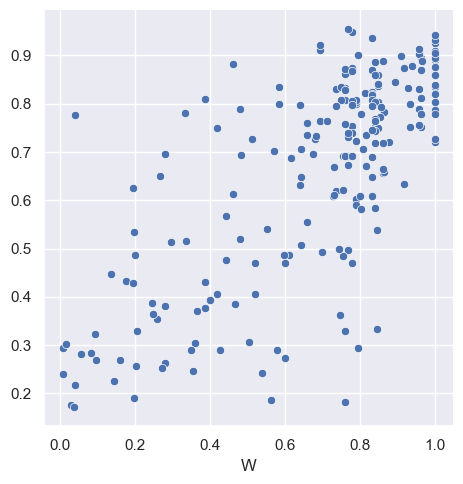

In [29]:
sns.set_theme()
sns.relplot(x=Y_w_test, y=predict_w)

In [30]:
X2_train, X2_test, Y_rho_train, Y_rho_test  = train_test_split(X,Y_rho, train_size=0.7, random_state=42)

In [31]:
scaler_2 = StandardScaler()
X2_train = scaler_2.fit_transform(X2_train)
X2_test = scaler_2.fit_transform(X2_test)

In [32]:
rf_rho=ensemble.RandomForestRegressor(random_state=42)
rf_rho.fit(X2_train,Y_rho_train)

RandomForestRegressor(random_state=42)

In [33]:
predict_rho=rf_rho.predict(X2_test)

In [34]:
mae_rho=mean_absolute_error(Y_rho_test,predict_rho)
mse_rho=mean_squared_error(Y_rho_test,predict_rho)
rmse_rho=mse_rho**0.5
r2_score_rho=r2_score(Y_rho_test,predict_rho)

In [35]:
print('MAE: {:.3f}'.  format(mae_rho), "MSE: {:.3f}". format(mse_rho), "RMSE:{:.3f}". format(rmse_rho), "r2_score: {:.3f}".
      format(r2_score_rho))

MAE: 0.146 MSE: 0.033 RMSE:0.183 r2_score: -0.073


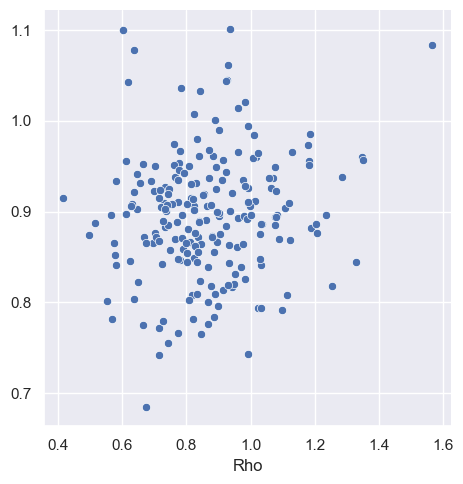

In [36]:
sns.set_theme()
sns.relplot(x=Y_rho_test, y=predict_rho)

In [37]:
df = pd.DataFrame({'name': X.columns, 'val': rf_w.feature_importances_})

In [38]:
df=df.sort_values(by ='val', ascending=False)
df.transpose()

,7,1,5,3,16,2,4,6,0,14,11,9,10,15,8,64,46,152,86,154,123,56,177,81,62,138,198,88,171,143,75,101,161,76,153,147,99,112,107,162,13,100,174,189,202,95,82,113,52,200,97,119,157,140,160,41,67,42,180,22,44,187,94,139,31,77,78,203,126,118,211,65,80,43,28,12,186,21,110,45,103,185,146,93,17,148,61,35,135,68,40,223,54,129,170,179,18,50,114,192,116,33,29,32,102,197,156,108,39,111,188,20,79,53,24,63,19,164,182,194,117,30,196,55,23,124,57,172,168,175,149,58,104,91,83,199,183,69,115,137,72,184,74,176,128,159,166,109,85,122,193,142,70,226,25,144,173,51,141,36,181,73,204,201,221,212,66,90,96,125,236,163,34,89,151,165,178,224,231,134,136,26,132,214,84,105,133,49,59,158,37,218,222,131,206,217,220,169,216,121,155,235,190,48,27,230,47,98,225,208,229,210,205,232,234,195,207,150,213,228,233,120,145,92,106,127,167,38,130,215,227,191,87,60,219,209,71
name,SPm_4,SPm_1,SPm_3,SPm_2,Dte.1,P_1,P_2,P_3,Year,J,T3,T1,T2,Y,P_4,PF_5-D,PF_3-H,2nd_place_Ukraine,1st_place_Germany,2nd_place_United States,2nd_place_Georgia,PF_4-G,3rd_place_Iran,1st_place_Chinese Taipei,PF_5-B,2nd_place_Poland,3rd_place_Thailand,1st_place_Hungary,3rd_place_Georgia,2nd_place_Slovakia,1st_place_Austria,1st_place_South Korea,3rd_place_Bulgaria,1st_place_Belarus,2nd_place_United Kingdom,2nd_place_Sweden,1st_place_Singapore,2nd_place_Belarus,1st_place_Ukraine,3rd_place_Canada,T,1st_place_Slovakia,3rd_place_Hungary,3rd_place_Russia,3rd_place_United Kingdom,1st_place_Poland,1st_place_Croatia,2nd_place_Brazil,PF_4-C,3rd_place_Ukraine,1st_place_Russia,2nd_place_Czech Republic,3rd_place_Austria,2nd_place_Russia,3rd_place_Brazil,PF_3-C,PF_5-G,PF_3-D,3rd_place_Macao,PF_1-F,PF_3-F,3rd_place_Poland,1st_place_New Zealand,2nd_place_Romania,PF_2-D,1st_place_Brazil,1st_place_Bulgaria,3rd_place_United States,2nd_place_Hungary,2nd_place_Croatia,4th_place_Chinese Taipei,PF_5-E,1st_place_China,PF_3-E,PF_2-A,T4,3rd_place_Pakistan,PF_1-E,2nd_place_Australia,PF_3-G,1st_place_Switzerland,3rd_place_No team,2nd_place_South Korea,1st_place_Netherlands,PF_1-A,2nd_place_Switzerland,PF_5-A,PF_2-H,2nd_place_New Zealand,PF_5-H,PF_3-B,4th_place_No team,PF_4-E,2nd_place_Iran,3rd_place_France,3rd_place_Kenya,PF_1-B,PF_4-A,2nd_place_Bulgaria,3rd_place_Slovakia,2nd_place_China,PF_2-F,PF_2-B,PF_2-E,1st_place_Sweden,3rd_place_Switzerland,3rd_place_Australia,1st_place_United Kingdom,PF_3-A,2nd_place_Austria,3rd_place_Romania,PF_1-D,1st_place_Canada,PF_4-D,PF_1-H,PF_5-C,PF_1-C,3rd_place_China,3rd_place_Netherlands,3rd_place_South Africa,2nd_place_Chinese Taipei,PF_2-C,3rd_place_Sweden,PF_4-F,PF_1-G,2nd_place_Germany,PF_4-H,3rd_place_Germany,3rd_place_Czech Republic,3rd_place_India,2nd_place_Thailand,PF_4-I,1st_place_Thailand,1st_place_Iran,1st_place_Czech Republic,3rd_place_Turkey,3rd_place_New Zealand,PF_5-I,2nd_place_Canada,2nd_place_Pakistan,PF_F-A,3rd_place_Nigeria,1st_place_Australia,3rd_place_Indonesia,2nd_place_Indonesia,3rd_place_Belarus,3rd_place_Croatia,1st_place_United States,1st_place_Georgia,2nd_place_France,3rd_place_Slovenia,2nd_place_Singapore,PF_5-J,4th_place_Russia,PF_1-I,2nd_place_Slovenia,3rd_place_Greece,PF_4-B,2nd_place_Serbia,PF_2-I,3rd_place_Mexico,PF_S-A,4th_place_Australia,3rd_place_United Arab Em,4th_place_Netherlands,4th_place_Czech Republic,PF_5-F,1st_place_Indonesia,1st_place_Romania,2nd_place_Greece,4th_place_United States,3rd_place_Chile,PF_2-G,1st_place_India,2nd_place_USSR-Riga,3rd_place_Chinese Taipei,3rd_place_Kazakhstan,4th_place_Pakistan,4th_place_Sweden,2nd_place_Netherlands,2nd_place_Nigeria,PF_1-J,2nd_place_Macao,4th_place_Greece,1st_place_France,1st_place_USSR-Moscow,2nd_place_Mexico,PF_3-K,PF_4-J,3rd_place_Azerbaijan,PF_2-J,4th_place_Kenya,4th_place_Nigeria,2nd_place_Kenya,4th_place_Belarus,4th_place_Iran,4th_place_Mexico,3rd_place_Finland,4th_place_India,2nd_place_Finland,2nd_place_Uzbekistan,4th_place_United Kingdom,3rd_place_Serbia,PF_3-J,PF_1-K,4th_place_South Korea,PF_3-I,1st_place_Serbia,4th_place_Romania,4th_place_Canada,4th_place_Slovenia,4th_place_China,4th_place_Austria,4t

In [39]:
df2 = pd.DataFrame({'name': X.columns, 'val': rf_rho.feature_importances_})

In [40]:
df2=df2.sort_values(by ='val', ascending=False)
df2.transpose()

,1,3,0,5,6,2,16,4,7,118,11,14,31,10,45,9,157,15,147,61,196,93,43,27,75,161,113,68,152,123,94,81,146,24,171,86,180,99,137,29,53,162,190,174,17,154,83,51,110,101,202,114,77,188,18,20,200,54,148,182,56,39,112,129,44,197,57,179,198,88,126,189,140,76,65,12,8,187,95,40,100,66,186,103,82,80,30,153,119,116,143,21,176,97,124,107,104,193,23,69,159,32,52,64,144,177,46,223,73,42,67,117,62,28,138,178,173,102,35,74,208,108,22,169,132,207,135,111,168,184,26,25,139,41,63,166,85,13,91,231,55,183,203,181,149,160,78,172,164,199,79,156,109,134,194,72,115,70,131,170,192,201,125,185,84,19,34,96,50,120,128,89,47,175,221,87,204,133,58,151,158,33,163,141,122,36,49,142,48,228,225,136,222,229,60,155,213,59,98,235,105,233,211,224,234,150,145,214,205,216,220,230,130,90,210,121,226,218,217,236,206,212,195,92,127,37,106,232,165,191,219,71,227,38,209,215,167
name,SPm_1,SPm_2,Year,SPm_3,P_3,P_1,Dte.1,P_2,SPm_4,2nd_place_Croatia,T3,J,PF_2-D,T2,PF_3-G,T1,3rd_place_Austria,Y,2nd_place_Sweden,PF_5-A,3rd_place_Sweden,1st_place_Netherlands,PF_3-E,PF_1-K,1st_place_Austria,3rd_place_Bulgaria,2nd_place_Brazil,PF_5-H,2nd_place_Ukraine,2nd_place_Georgia,1st_place_New Zealand,1st_place_Chinese Taipei,2nd_place_South Korea,PF_1-H,3rd_place_Georgia,1st_place_Germany,3rd_place_Macao,1st_place_Singapore,2nd_place_Pakistan,PF_2-B,PF_4-D,3rd_place_Canada,3rd_place_Serbia,3rd_place_Hungary,PF_1-A,2nd_place_United States,1st_place_Czech Republic,PF_4-B,2nd_place_Australia,1st_place_South Korea,3rd_place_United Kingdom,2nd_place_Bulgaria,1st_place_Brazil,3rd_place_Romania,PF_1-B,PF_1-D,3rd_place_Ukraine,PF_4-E,2nd_place_Switzerland,3rd_place_Netherlands,PF_4-G,PF_3-A,2nd_place_Belarus,2nd_place_Iran,PF_3-F,3rd_place_Switzerland,PF_4-H,3rd_place_Kenya,3rd_place_Thailand,1st_place_Hungary,2nd_place_Hungary,3rd_place_Russia,2nd_place_Russia,1st_place_Belarus,PF_5-E,T4,P_4,3rd_place_Poland,1st_place_Poland,PF_3-B,1st_place_Slovakia,PF_5-F,3rd_place_Pakistan,1st_place_Switzerland,1st_place_Croatia,1st_place_China,PF_2-C,2nd_place_United Kingdom,2nd_place_Czech Republic,2nd_place_China,2nd_place_Slovakia,PF_1-E,3rd_place_Indonesia,1st_place_Russia,2nd_place_Germany,1st_place_Ukraine,1st_place_Thailand,3rd_place_Slovenia,PF_1-G,PF_5-I,3rd_place_Belarus,PF_2-E,PF_4-C,PF_5-D,2nd_place_Slovenia,3rd_place_Iran,PF_3-H,4th_place_No team,PF_S-A,PF_3-D,PF_5-G,2nd_place_Chinese Taipei,PF_5-B,PF_2-A,2nd_place_Poland,3rd_place_Kazakhstan,3rd_place_Greece,1st_place_Sweden,PF_2-H,1st_place_Australia,4th_place_Canada,1st_place_United Kingdom,PF_1-F,3rd_place_Finland,2nd_place_Macao,4th_place_Bulgaria,2nd_place_New Zealand,2nd_place_Austria,3rd_place_Czech Republic,3rd_place_Nigeria,PF_1-J,PF_1-I,2nd_place_Romania,PF_3-C,PF_5-C,3rd_place_Croatia,1st_place_Georgia,T,1st_place_Iran,4th_place_Sweden,PF_4-F,3rd_place_New Zealand,3rd_place_United States,3rd_place_Mexico,2nd_place_Thailand,3rd_place_Brazil,1st_place_Bulgaria,3rd_place_Germany,3rd_place_China,3rd_place_Turkey,1st_place_Canada,3rd_place_Australia,1st_place_United States,2nd_place_Netherlands,3rd_place_South Africa,PF_F-A,2nd_place_Canada,PF_5-J,2nd_place_Kenya,3rd_place_France,3rd_place_Slovakia,3rd_place_United Arab Em,2nd_place_Greece,3rd_place_No team,1st_place_France,PF_1-C,PF_2-G,1st_place_Romania,PF_4-A,2nd_place_Czechoslovakia,2nd_place_Indonesia,1st_place_India,PF_3-I,3rd_place_India,4th_place_Netherlands,1st_place_Greece,4th_place_Australia,2nd_place_Mexico,PF_4-I,2nd_place_USSR-Riga,3rd_place_Azerbaijan,PF_2-F,3rd_place_Chile,2nd_place_Serbia,2nd_place_France,PF_2-I,PF_3-K,2nd_place_Singapore,PF_3-J,4th_place_Slovakia,4th_place_Romania,2nd_place_Nigeria,4th_place_Nigeria,4th_place_Slovenia,PF_4-K,2nd_place_Uzbekistan,4th_place_Georgia,PF_4-J,1st_place_Serbia,4th_place_United Kingdom,1st_place_USSR-Moscow,4th_place_Ukraine,4th_place_Chinese Taipei,4th_place_Pakistan,4th_place_United Arab Em,2nd_place_Turkey,2nd_place_South Africa,4th_place_Greece,4th_place_Austria,4th_place_India,4th_place_Mexico,4th_place_South Korea,2nd_place_Kazak

Получили неплохие значения для W, а значения Rho на уровне случайного предсказания.
Также видим, что на результат категориальные параметры (номер боя и название команд) слабо влияют. Поэтому для упрощения наших моделей можно попробовать обучать модели без этих данных.

---------------------

## Проведем анализ RandomForestRegressor на данных без категориальных признаков, выполнив все теже самые действия, но с использованием подбора параметров.

In [41]:
data2=data2.drop(['PF','1st_place','2nd_place','3rd_place','4th_place'],axis=1)

In [42]:
data2

,Year,SPm_1,P_1,SPm_2,P_2,SPm_3,P_3,SPm_4,P_4,T1,T2,T3,T4,W,Rho,T,J,Y,Dte.1
0,1990,46.58,7,43.08,2,35.79,5,31.33,0,2,3,1,0,0.866,0.858,3,11,0,161
1,1990,42.50,6,39.87,3,29.97,4,25.51,0,3,1,2,0,0.551,1.170,3,7,0,164
2,1993,39.80,8,37.30,11,22.60,15,18.14,0,1,2,3,0,0.796,0.927,3,7,0,170
3,1993,37.40,9,33.90,7,30.30,3,25.84,0,1,2,3,0,0.327,0.804,3,7,0,171
4,1993,48.40,2,43.80,14,41.00,12,36.54,0,3,1,2,0,0.500,1.337,3,7,0,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2022,27.60,7,27.50,15,24.50,5,20.04,0,1,3,2,0,0.040,0.895,3,5,0,202
703,2022,41.10,6,24.30,7,20.10,11,15.64,0,2,3,1,0,0.958,0.882,3,5,3,202
704,2022,45.80,9,28.40,7,26.70,11,22.24,0,1,3,2,0,0.832,0.771,3,5,2,202
705,2022,37.00,16,32.40,2,26.90,1,22.44,0,1,3,2,0,0.933,0.827,3,5,2,202


In [43]:
X=data2.copy()
X.drop(labels=['W','Rho'], axis=1, inplace=True)
Y_w = data2.W
Y_rho = data2.Rho

In [44]:
X_train, X_test, Y_w_train, Y_w_test  = train_test_split(X,Y_w, train_size=0.7, random_state=42)

In [45]:
scaler_3 = StandardScaler()
X_train = scaler_3.fit_transform(X_train)
X_test = scaler_3.fit_transform(X_test)

In [46]:
pipe_w = Pipeline([('classifier', [ensemble.RandomForestRegressor()])]) 
param_grid_w = [{'classifier' : [ensemble.RandomForestRegressor()],'classifier__n_estimators': [100, 200],'classifier__min_samples_split': [8, 10],'classifier__min_samples_leaf': [3, 4, 5],'classifier__max_depth': [None, 80, 90,100]}]

In [47]:
rf_w = GridSearchCV(pipe_w, param_grid = param_grid_w, cv = 5, n_jobs=-1, scoring='r2')

In [48]:
rf_w.fit(X_train,Y_w_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        [RandomForestRegressor()])]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestRegressor(min_samples_leaf=4,
                                                               min_samples_split=10,
                                                               n_estimators=200)],
                          'classifier__max_depth': [None, 80, 90, 100],
                          'classifier__min_samples_leaf': [3, 4, 5],
                          'classifier__min_samples_split': [8, 10],
                          'classifier__n_estimators': [100, 200]}],
             scoring='r2')

In [49]:
print("Лучшие параметры RandomForestRegressor:\n{}".format(rf_w.best_estimator_))

Лучшие параметры RandomForestRegressor:
Pipeline(steps=[('classifier',
                 RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=200))])


In [50]:
predict_w1=rf_w.predict(X_test)
mae_w1=mean_absolute_error(Y_w_test,predict_w1)
mse_w1=mean_squared_error(Y_w_test,predict_w1)
rmse_w1=mse_w1**0.5
r2_score_w1=r2_score(Y_w_test,predict_w1)
print('MAE: {:.3f}'.  format(mae_w1), "MSE: {:.3f}". format(mse_w1), "RMSE:{:.3f}". format(rmse_w1), "r2_score: {:.3f}".
      format(r2_score_w1))

MAE: 0.143 MSE: 0.034 RMSE:0.183 r2_score: 0.529


In [51]:
X2_train, X2_test, Y_rho_train, Y_rho_test  = train_test_split(X,Y_rho, train_size=0.7, random_state=42)


In [52]:
scaler_4 = StandardScaler()
X2_train = scaler_4.fit_transform(X2_train)
X2_test = scaler_4.fit_transform(X2_test)

In [53]:
pipe_rho = Pipeline([('classifier', [ensemble.RandomForestRegressor()])]) 
param_grid_rho = [{'classifier' : [ensemble.RandomForestRegressor()],'classifier__n_estimators': [100, 200],'classifier__min_samples_split': [8, 10],'classifier__min_samples_leaf': [3, 4, 5],'classifier__max_depth': [None, 80, 90,100]}]

In [54]:
rf_rho = GridSearchCV(pipe_rho, param_grid = param_grid_rho, cv = 5, n_jobs=-1, scoring='r2')

In [55]:
rf_rho.fit(X2_train,Y_rho_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        [RandomForestRegressor()])]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestRegressor(max_depth=100,
                                                               min_samples_leaf=3,
                                                               min_samples_split=8,
                                                               n_estimators=200)],
                          'classifier__max_depth': [None, 80, 90, 100],
                          'classifier__min_samples_leaf': [3, 4, 5],
                          'classifier__min_samples_split': [8, 10],
                          'classifier__n_estimators': [100, 200]}],
             scoring='r2')

In [56]:
print("Лучшие параметры RandomForestRegressor:\n{}".format(rf_rho.best_estimator_))

Лучшие параметры RandomForestRegressor:
Pipeline(steps=[('classifier',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=3,
                                       min_samples_split=8,
                                       n_estimators=200))])


In [57]:
predict_rho1=rf_rho.predict(X2_test)
mae_rho1=mean_absolute_error(Y_rho_test,predict_rho1)
mse_rho1=mean_squared_error(Y_rho_test,predict_rho1)
rmse_rho1=mse_rho1**0.5
r2_score_rho1=r2_score(Y_rho_test,predict_rho1)
print('MAE: {:.3f}'.  format(mae_rho1), "MSE: {:.3f}". format(mse_rho1), "RMSE:{:.3f}". format(rmse_rho1), "r2_score: {:.3f}".
      format(r2_score_rho1))

MAE: 0.142 MSE: 0.032 RMSE:0.178 r2_score: -0.021


Из полученных данных видим, что удаление категориальных признаков практически не повлияло на результаты.
Загрузим данные для реконструирования целевых меток и выполним ту же самую обработку данных. Полученные результаты сохраним.

In [58]:
data_predict = pd.read_excel('Predict.xlsx', usecols =['Year', 'SPm_1', 'P_1','SPm_2','P_2','SPm_3','P_3','SPm_4','P_4','T1','T2','T3','T4','T','J','Y','Dte.1'])

In [59]:
data_predict

,Year,SPm_1,P_1,SPm_2,P_2,SPm_3,P_3,SPm_4,P_4,T1,T2,T3,T4,T,J,Y,Dte.1
0,1988,51.50,9,49.40,3,49.20,6.0,48.50,7.0,4,3,1.0,2.0,4,11,0,92
1,1989,56.49,6,55.90,16,54.15,5.0,49.49,9.0,1,4,3.0,2.0,4,8,0,90
2,1989,56.78,9,56.19,5,54.45,16.0,50.37,6.0,2,4,3.0,1.0,4,8,0,90
3,1990,45.12,1,44.25,7,43.66,5.0,NaN,NaN,1,2,3.0,NaN,3,10,0,161
4,1990,45.70,12,43.95,11,39.00,16.0,NaN,NaN,2,1,3.0,NaN,3,11,0,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,2008,42.90,16,42.50,12,40.80,17.0,NaN,NaN,2,3,1.0,NaN,3,6,0,146
371,2008,41.20,13,34.70,5,33.10,12.0,NaN,NaN,2,3,1.0,NaN,3,6,1,146
372,2008,46.50,17,45.70,9,39.40,3.0,NaN,NaN,2,1,3.0,NaN,3,6,1,146
373,2008,43.80,8,42.10,13,41.20,10.0,NaN,NaN,2,1,3.0,NaN,3,6,0,146


In [60]:
data_predict.loc[(data_predict['SPm_3'].isnull()), 'SPm_3']=data_predict['SPm_2']-3.64
data_predict.loc[(data_predict['P_3'].isnull()), 'P_3']=0
data_predict.loc[(data_predict['T3'].isnull()), 'T3']=0
data_predict.loc[(data_predict['SPm_4'].isnull()), 'SPm_4']=data_predict['SPm_3']-4.46
data_predict.loc[(data_predict['P_4'].isnull()), 'P_4']=0
data_predict.loc[(data_predict['T4'].isnull()), 'T4']=0
data_predict["P_3"] = data_predict['P_3'].astype('int')
data_predict["P_4"] = data_predict['P_4'].astype('int')
data_predict["T3"] = data_predict['T3'].astype('int')
data_predict["T4"] = data_predict['T4'].astype('int')

In [61]:
scaler_predict = StandardScaler()
data_predict = scaler_predict.fit_transform(data_predict)

In [62]:
predict_output_w1=rf_w.predict(data_predict)
predict_output_rho1=rf_rho.predict(data_predict)

In [63]:
output_rf = pd.read_excel('Predict.xlsx')

In [64]:
output_rf['W']=predict_output_w1
output_rf.insert(19,'Rho_predict',predict_output_rho1)

In [65]:
output_rf.to_excel('outputRF.xlsx', index= False)

--------------------------

## Проведем реконструирование целевых значений с использованием LGBMRegressor

In [66]:
pipe_w = Pipeline([('classifier', [LGBMRegressor()])]) 
param_grid_w = [{'classifier' : [LGBMRegressor()],'classifier__learning_rate': [0.1, 0.01],'classifier__num_iterations': [40, 50,60],'classifier__max_bin': [50, 60, 70]}]

In [67]:
model_w = GridSearchCV(pipe_w, param_grid = param_grid_w, cv = 5, n_jobs=-1, scoring='r2')

In [68]:
model_w.fit(X_train,Y_w_train)

C:\Users\HP\anaconda3\envs\tf2\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', [LGBMRegressor()])]),
             n_jobs=-1,
             param_grid=[{'classifier': [LGBMRegressor(max_bin=60,
                                                       num_iterations=40)],
                          'classifier__learning_rate': [0.1, 0.01],
                          'classifier__max_bin': [50, 60, 70],
                          'classifier__num_iterations': [40, 50, 60]}],
             scoring='r2')

In [69]:
print("Лучшие параметры RandomForest:\n{}".format(model_w.best_estimator_))

Лучшие параметры RandomForest:
Pipeline(steps=[('classifier', LGBMRegressor(max_bin=60, num_iterations=40))])


In [70]:
predict_w2=model_w.predict(X_test)
mae_w2=mean_absolute_error(Y_w_test,predict_w2)
mse_w2=mean_squared_error(Y_w_test,predict_w2)
rmse_w2=mse_w2**0.5
r2_score_w2=r2_score(Y_w_test,predict_w2)
print('MAE: {:.3f}'.  format(mae_w2), "MSE: {:.3f}". format(mse_w2), "RMSE:{:.3f}". format(rmse_w2), "r2_score: {:.3f}".
      format(r2_score_w2))

MAE: 0.138 MSE: 0.032 RMSE:0.180 r2_score: 0.547


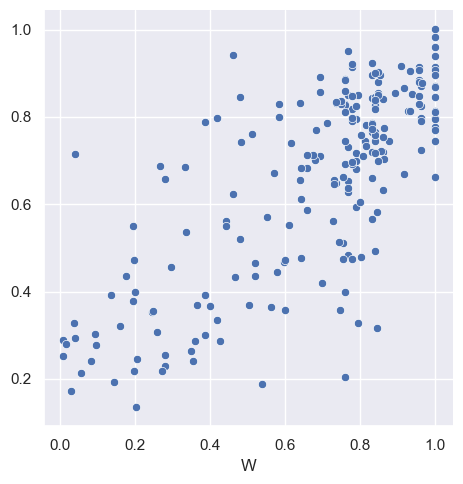

In [71]:
sns.set_theme()
sns.relplot(x=Y_w_test, y=predict_w2)

In [72]:
pipe_rho = Pipeline([('classifier', [LGBMRegressor()])]) 
param_grid_rho = [{'classifier' : [LGBMRegressor()],'classifier__learning_rate': [0.1, 0.01],'classifier__num_iterations': [40, 50,60],'classifier__max_bin': [50, 60, 70]}]

In [73]:
model_rho = GridSearchCV(pipe_rho, param_grid = param_grid_rho, cv = 5, n_jobs=-1, scoring='r2')

In [74]:
model_rho.fit(X2_train,Y_rho_train)

C:\Users\HP\anaconda3\envs\tf2\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', [LGBMRegressor()])]),
             n_jobs=-1,
             param_grid=[{'classifier': [LGBMRegressor(learning_rate=0.01,
                                                       max_bin=60,
                                                       num_iterations=40)],
                          'classifier__learning_rate': [0.1, 0.01],
                          'classifier__max_bin': [50, 60, 70],
                          'classifier__num_iterations': [40, 50, 60]}],
             scoring='r2')

In [75]:
print("Лучшие параметры RandomForest:\n{}".format(model_rho.best_estimator_))

Лучшие параметры RandomForest:
Pipeline(steps=[('classifier',
                 LGBMRegressor(learning_rate=0.01, max_bin=60,
                               num_iterations=40))])


In [76]:
predict_rho2=model_rho.predict(X2_test)
mae_rho2=mean_absolute_error(Y_rho_test,predict_rho2)
mse_rho2=mean_squared_error(Y_rho_test,predict_rho2)
rmse_rho2=mse_rho2**0.5
r2_score_rho2=r2_score(Y_rho_test,predict_rho2)
print('MAE: {:.3f}'.  format(mae_rho2), "MSE: {:.3f}". format(mse_rho2), "RMSE:{:.3f}". format(rmse_rho2), "r2_score: {:.3f}".
      format(r2_score_rho2))

MAE: 0.141 MSE: 0.032 RMSE:0.178 r2_score: -0.024


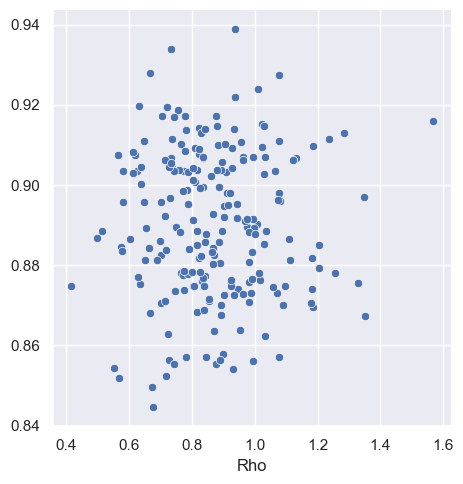

In [77]:
sns.set_theme()
sns.relplot(x=Y_rho_test, y=predict_rho2)

LGBMRegressor не дал большой прибавки к точности и к улучшению r2 score

In [78]:
predict_output_w2=model_w.predict(data_predict)
predict_output_rho2=model_rho.predict(data_predict)
output_LGBM = pd.read_excel('Predict.xlsx')
output_LGBM['W']=predict_output_w2
output_LGBM.insert(19,'Rho_predict',predict_output_rho2)
output_LGBM.to_excel('output_LGBMRegressor.xlsx', index= False)

---------------------------------------

## Произведем реконструирование целевых значений с использованием нейронных сетей

In [79]:
model_w = tf.keras.models.Sequential()
model_w.add(tf.keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:]))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(128, activation="relu"))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(256, activation="relu"))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(128, activation="relu"))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(64, activation="relu"))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(32, activation="relu"))
model_w.add(tf.keras.layers.Dropout(0.5))
model_w.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [80]:
model_w.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [81]:
model_w.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.mae])

In [82]:
history_w=model_w.fit(X_train, Y_w_train, epochs=300, validation_split=0.2, verbose=0)

In [83]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error MSE')
  plt.legend()
  plt.grid(True)

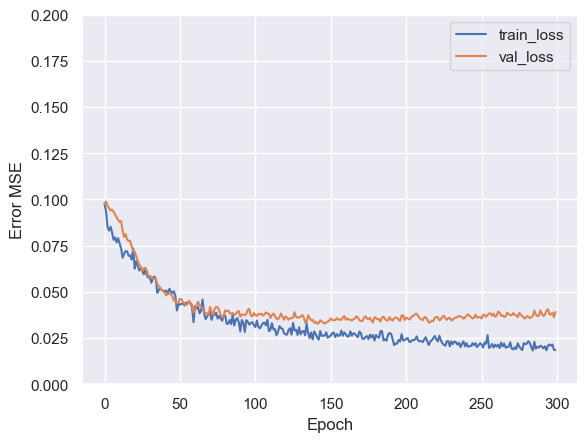

In [84]:
plot_loss(history_w)

In [85]:
model_w.evaluate(X_test, Y_w_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.0423 - mean_absolute_error: 0.1668


[0.04227409511804581, 0.16677530109882355]

In [86]:
predict_w3=model_w.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [87]:
mae_w3=mean_absolute_error(Y_w_test,predict_w3)
mse_w3=mean_squared_error(Y_w_test,predict_w3)
rmse_w3=mse_w3**0.5
r2_score_w3=r2_score(Y_w_test,predict_w3)
print('MAE: {:.3f}'.  format(mae_w3), "MSE: {:.3f}". format(mse_w3), "RMSE:{:.3f}". format(rmse_w3), "r2_score: {:.3f}".
      format(r2_score_w3))

MAE: 0.167 MSE: 0.042 RMSE:0.206 r2_score: 0.408


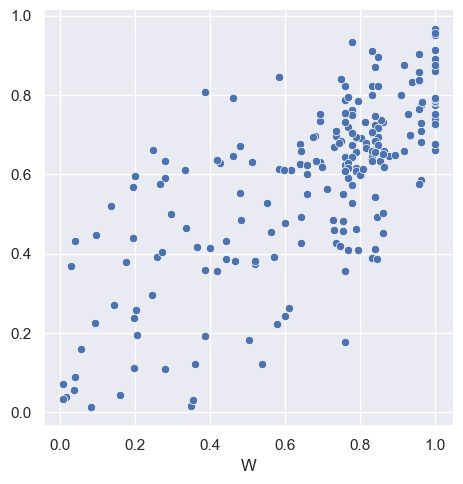

In [88]:
sns.set_theme()
sns.relplot(x=Y_w_test, y=predict_w3.reshape(-1))

In [89]:
model_rho = tf.keras.models.Sequential()
model_rho.add(tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]))
model_rho.add(tf.keras.layers.Dropout(0.25))
model_rho.add(tf.keras.layers.Dense(64, activation="relu"))
model_rho.add(tf.keras.layers.Dropout(0.25))
model_rho.add(tf.keras.layers.Dense(128, activation="relu"))
model_rho.add(tf.keras.layers.Dropout(0.25))
model_rho.add(tf.keras.layers.Dense(64, activation="relu"))
model_rho.add(tf.keras.layers.Dropout(0.25))
model_rho.add(tf.keras.layers.Dense(32, activation="relu"))
model_rho.add(tf.keras.layers.Dropout(0.25))
model_rho.add(tf.keras.layers.Dense(1))

In [90]:
model_rho.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                576       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [91]:
model_rho.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.mae])

In [92]:
history_rho=model_rho.fit(X2_train, Y_rho_train, epochs=300, validation_split=0.2, verbose=0)

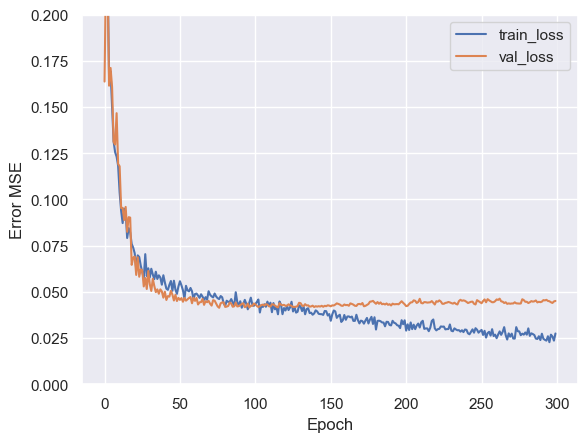

In [93]:
plot_loss(history_rho)

In [94]:
model_rho.evaluate(X2_test, Y_rho_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.0343 - mean_absolute_error: 0.1415


[0.0342758372426033, 0.14148931205272675]

In [95]:
predict_rho3=model_rho.predict(X2_test)

7/7 [==============================] - 0s 3ms/step


In [96]:
mae_rho3=mean_absolute_error(Y_rho_test,predict_rho3)
mse_rho3=mean_squared_error(Y_rho_test,predict_rho3)
rmse_rho3=mse_rho3**0.5
r2_score_rho3=r2_score(Y_rho_test,predict_rho3)
print('MAE: {:.3f}'.  format(mae_rho3), "MSE: {:.3f}". format(mse_rho3), "RMSE:{:.3f}". format(rmse_rho3), "r2_score: {:.3f}".
      format(r2_score_rho3))

MAE: 0.141 MSE: 0.034 RMSE:0.185 r2_score: -0.104


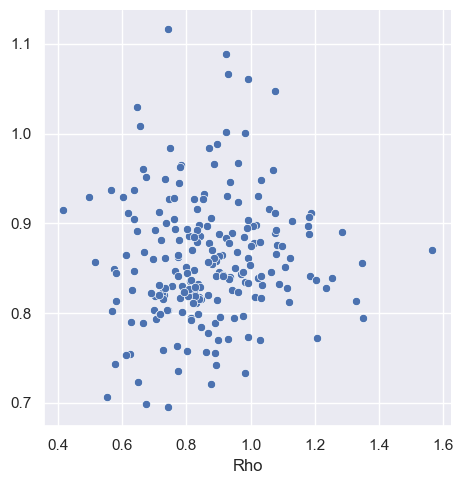

In [97]:
sns.set_theme()
sns.relplot(x=Y_rho_test, y=predict_rho3.reshape(-1))

In [98]:
predict_output_w3=model_w.predict(data_predict)
predict_ouput_rho3=model_rho.predict(data_predict)
output_NN = pd.read_excel('Predict.xlsx')
output_NN['W']=predict_output_w3
output_NN.insert(19,'Rho_predict',predict_ouput_rho3)
output_NN.to_excel('output_NN.xlsx', index= False)

12/12 [==============================] - 0s 3ms/step


In [99]:
result_w = pd.DataFrame({'name': ['RF', 'LGBMRegressor', 'NN'], 'mae': [mae_w1, mae_w2,mae_w3], 'mse': [mse_w1, mse_w2,mse_w3],
                      'rmse': [rmse_w1, rmse_w2,rmse_w3], 'r2_score': [r2_score_w1, r2_score_w2,r2_score_w3]})

# Сводная таблица результатов реконструирования W

In [100]:
result_w

,name,mae,mse,rmse,r2_score
0,RF,0.142507,0.033608,0.183324,0.529269
1,LGBMRegressor,0.138347,0.032361,0.179891,0.546732
2,NN,0.166775,0.042274,0.205607,0.407878


In [101]:
result_rho = pd.DataFrame({'name': ['RF', 'LGBMRegressor', 'NN'], 'mae': [mae_rho1, mae_rho2,mae_rho3],
                           'mse': [mse_rho1, mse_rho2,mse_rho3],
                      'rmse': [rmse_rho1, rmse_rho2,rmse_rho3], 'r2_score': [r2_score_rho1, r2_score_rho2,r2_score_rho3]})

# Сводная таблица результатов реконструирования Rho

In [102]:
result_rho

,name,mae,mse,rmse,r2_score
0,RF,0.141922,0.031707,0.178064,-0.020800
1,LGBMRegressor,0.140662,0.031819,0.178379,-0.024410
2,NN,0.141489,0.034276,0.185137,-0.103506


In [103]:
predict_output_w1.shape

(375,)

In [104]:
predict_output_w2.shape

(375,)

In [105]:
predict_output_w3.reshape(-1).shape

(375,)

In [106]:
d1=pd.DataFrame({'Year':output_NN.Year, 'W':predict_output_w1, 'name':'RF'})
d2=pd.DataFrame({'Year':output_NN.Year,'W':predict_output_w2, 'name':'LGBMRegressor'})
d3=pd.DataFrame({'Year':output_NN.Year,'W':predict_output_w3.reshape(-1), 'name':'NN'})

In [107]:
d4=pd.concat([d1, d2, d3], ignore_index = True)

## Реконструированные коэффициенты Кендалла для трех моделей (по отдельности)

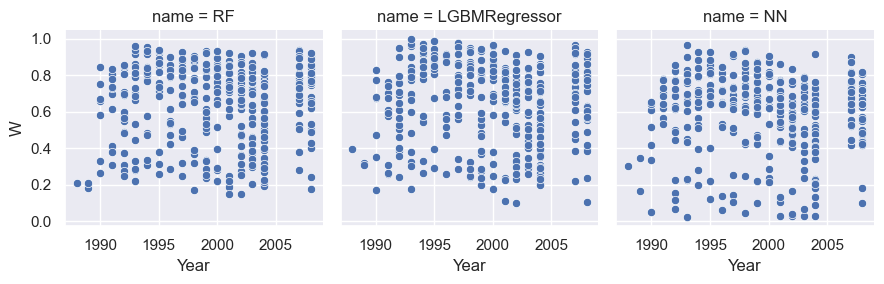

In [113]:
g = sns.FacetGrid(data=d4, col='name', col_wrap= 3 )
g.map(sns.scatterplot, 'Year', 'W')

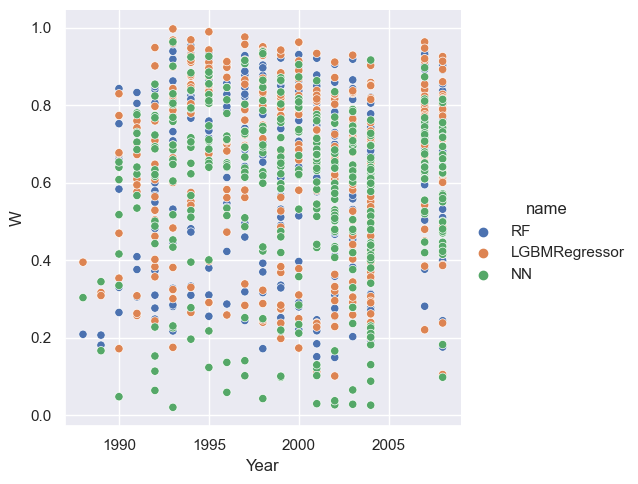

In [108]:
sns.relplot(
    data=d4,
    x="Year", y="W", hue='name')

График коэффициентов Кендалла (Train)

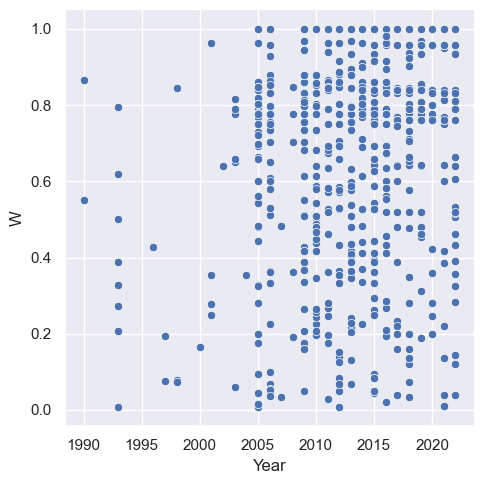

In [114]:
sns.relplot(
    data=data,
    x="Year", y="W", )

### В итоге получилось успешно реконструировать Кендалла рандомФорестом и LGBM и нейронными сетями. Rho вообще неудается определить (случайное предсказание)

### Проблематика реконструирования данных: 1) Мало данных 2) Разное число команд в боях, что не позволяет равноценно определить целевые значения

# Дополнительная проверка реконструированных значений коэффициентов Кендалла

In [169]:
df = pd.read_excel('TestTrain.xlsx', usecols =['Year', 'SPm_1', 'SPm_2','SPm_3','SPm_4','W'])

In [170]:
df

,Year,SPm_1,SPm_2,SPm_3,SPm_4,W
0,1990,46.58,43.08,35.79,NaN,0.866
1,1990,42.50,39.87,29.97,NaN,0.551
2,1993,39.80,37.30,22.60,NaN,0.796
3,1993,37.40,33.90,30.30,NaN,0.327
4,1993,48.40,43.80,41.00,NaN,0.500
...,...,...,...,...,...,...
702,2022,27.60,27.50,24.50,NaN,0.040
703,2022,41.10,24.30,20.10,NaN,0.958
704,2022,45.80,28.40,26.70,NaN,0.832
705,2022,37.00,32.40,26.90,NaN,0.933


In [171]:
df.insert(5, 'v12',df.SPm_1-df.SPm_2)
df.insert(6, 'v23',df.SPm_2-df.SPm_3)
df.insert(7, 'v34',df.SPm_3-df.SPm_4)

In [172]:
df

,Year,SPm_1,SPm_2,SPm_3,SPm_4,v12,v23,v34,W
0,1990,46.58,43.08,35.79,NaN,3.50,7.29,NaN,0.866
1,1990,42.50,39.87,29.97,NaN,2.63,9.90,NaN,0.551
2,1993,39.80,37.30,22.60,NaN,2.50,14.70,NaN,0.796
3,1993,37.40,33.90,30.30,NaN,3.50,3.60,NaN,0.327
4,1993,48.40,43.80,41.00,NaN,4.60,2.80,NaN,0.500
...,...,...,...,...,...,...,...,...,...
702,2022,27.60,27.50,24.50,NaN,0.10,3.00,NaN,0.040
703,2022,41.10,24.30,20.10,NaN,16.80,4.20,NaN,0.958
704,2022,45.80,28.40,26.70,NaN,17.40,1.70,NaN,0.832
705,2022,37.00,32.40,26.90,NaN,4.60,5.50,NaN,0.933


In [173]:
df.insert(8, 'avg',(df.v12+df.v23+df.v34)/3)

In [174]:
df.loc[(df['SPm_3'].isnull()), 'avg']=df['v12']
df.loc[(df['SPm_4'].isnull()), 'avg']=(df['v12']+df['v23'])/2

In [175]:
df

,Year,SPm_1,SPm_2,SPm_3,SPm_4,v12,v23,v34,avg,W
0,1990,46.58,43.08,35.79,NaN,3.50,7.29,NaN,5.395,0.866
1,1990,42.50,39.87,29.97,NaN,2.63,9.90,NaN,6.265,0.551
2,1993,39.80,37.30,22.60,NaN,2.50,14.70,NaN,8.600,0.796
3,1993,37.40,33.90,30.30,NaN,3.50,3.60,NaN,3.550,0.327
4,1993,48.40,43.80,41.00,NaN,4.60,2.80,NaN,3.700,0.500
...,...,...,...,...,...,...,...,...,...,...
702,2022,27.60,27.50,24.50,NaN,0.10,3.00,NaN,1.550,0.040
703,2022,41.10,24.30,20.10,NaN,16.80,4.20,NaN,10.500,0.958
704,2022,45.80,28.40,26.70,NaN,17.40,1.70,NaN,9.550,0.832
705,2022,37.00,32.40,26.90,NaN,4.60,5.50,NaN,5.050,0.933


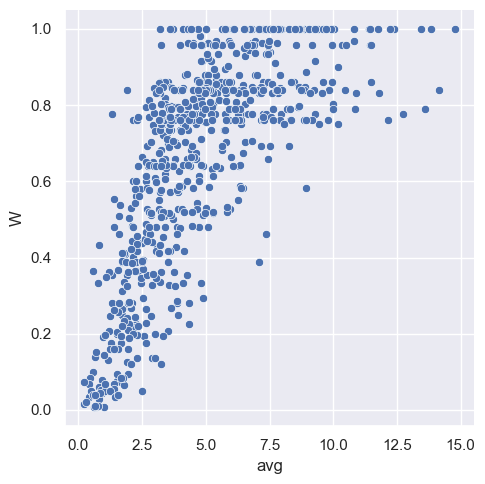

In [176]:
sns.relplot(
    data=df,
    x="avg", y="W")

На графике представлена зависимость Кендалла W от среднего "зазора" между результатами команд (0, если команды играют вничью; много, если команды сильно отличаются друг от друга). Данная зависимость нетривиальна. Хочется, чтобы реконструированные данные также следовали этой важной зависимости.

Проверка данного свойства для RandomForestRegressor

In [177]:
df1 = pd.read_excel('outputRF.xlsx', usecols =['Year', 'SPm_1', 'SPm_2','SPm_3','SPm_4','W'])

In [178]:
df1.insert(5, 'v12',df1.SPm_1-df1.SPm_2)
df1.insert(6, 'v23',df1.SPm_2-df1.SPm_3)
df1.insert(7, 'v34',df1.SPm_3-df1.SPm_4)
df1.insert(8, 'avg',(df1.v12+df1.v23+df1.v34)/3)

In [179]:
df1.loc[(df1['SPm_3'].isnull()), 'avg']=df1['v12']
df1.loc[(df1['SPm_4'].isnull()), 'avg']=(df1['v12']+df1['v23'])/2

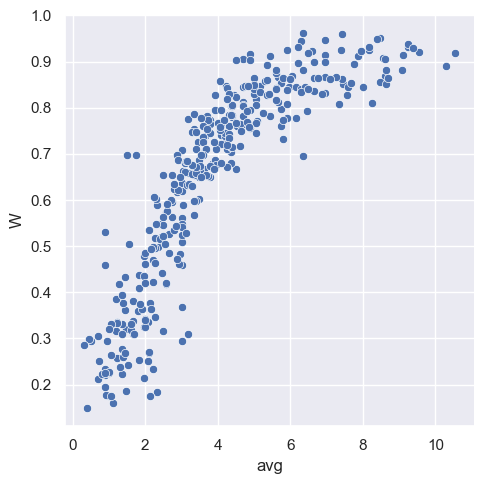

In [180]:
sns.relplot(
    data=df1,
    x="avg", y="W")

Проверка данного свойства для LGBMRegressor

In [181]:
df2 = pd.read_excel('output_LGBMRegressor.xlsx', usecols =['Year', 'SPm_1', 'SPm_2','SPm_3','SPm_4','W'])

In [182]:
df2.insert(5, 'v12',df2.SPm_1-df2.SPm_2)
df2.insert(6, 'v23',df2.SPm_2-df2.SPm_3)
df2.insert(7, 'v34',df2.SPm_3-df2.SPm_4)
df2.insert(8, 'avg',(df2.v12+df2.v23+df2.v34)/3)

In [183]:
df2.loc[(df2['SPm_3'].isnull()), 'avg']=df2['v12']
df2.loc[(df2['SPm_4'].isnull()), 'avg']=(df2['v12']+df2['v23'])/2

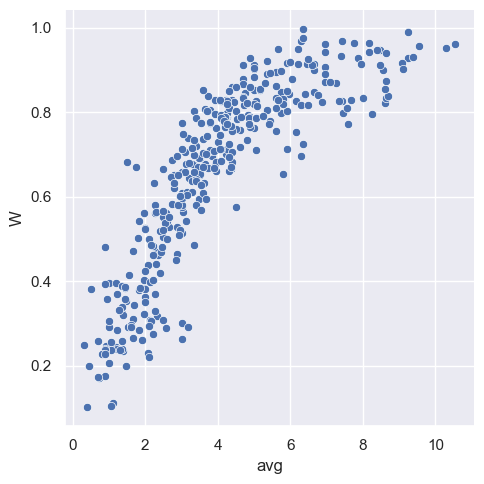

In [184]:
sns.relplot(
    data=df2,
    x="avg", y="W")

Проверка данного свойства для NN

In [185]:
df3 = pd.read_excel('output_NN.xlsx', usecols =['Year', 'SPm_1', 'SPm_2','SPm_3','SPm_4','W'])

In [186]:
df3.insert(5, 'v12',df3.SPm_1-df3.SPm_2)
df3.insert(6, 'v23',df3.SPm_2-df3.SPm_3)
df3.insert(7, 'v34',df3.SPm_3-df3.SPm_4)
df3.insert(8, 'avg',(df3.v12+df3.v23+df3.v34)/3)

In [187]:
df3.loc[(df3['SPm_3'].isnull()), 'avg']=df3['v12']
df3.loc[(df3['SPm_4'].isnull()), 'avg']=(df3['v12']+df3['v23'])/2

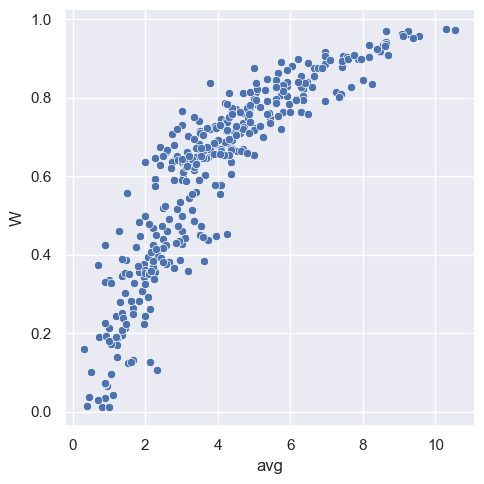

In [188]:
sns.relplot(
    data=df3,
    x="avg", y="W")

# Выводы:
    1. По результату дипломного проекта удалось реконструировать коэффициенты Кендалла
    2. Реконструированные значения W удовлетворяют как по точности, так и по корреляции и скрытым свойствам (последний пункт работы)
    3. Стандартные ошибки оценок жюри (Rho) реконструировать не удалось. Можно сделать вывод, что данная ошибка несет случайный характер и не имеет достаточной корреляции с предоставленными данными, что не позволяет произвести качественное предсказание.
    